In [1]:
import pypianoroll
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import io
import symusic
from pathlib import Path

# from chroma_subsystem.BinaryTokenizer import BinaryTokenizer, SimpleSerialChromaTokenizer
from miditok import REMI, TokenizerConfig
from transformers import RobertaTokenizer, RobertaTokenizerFast, RobertaModel

from torch.nn.utils.rnn import pad_sequence

from dataset_utils import LiveMelCATDataset, MelCATCollator
import midi_pianoroll_utils as mpu

/home/maximos/miniconda3/envs/chart_acc_gen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MAX_LENGTH = 1024

In [3]:
# midifolder = '/media/datadisk/datasets/GiantMIDI-PIano/midis_v1.2/midis'
midifolder = '/media/maindisk/maximos/data/POP909/aug_folder'
# midifolder = '/media/datadisk/data/Giant_PIano/'
dataset = LiveMelCATDataset(midifolder, segment_size=40)

/home/maximos/miniconda3/envs/chart_acc_gen/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
print(len(dataset))

46259


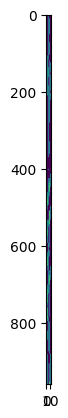

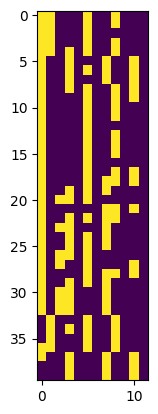

In [5]:
d0 = dataset[1]

In [6]:
d0

{'melody': tensor([ 5, 40, 97, 88, 14, 23, 60, 88, 17,  7, 41, 81, 17,  7, 62, 88, 17,  9,
         47, 88, 10,  7, 67, 88, 14,  8,  5, 49, 88, 14,  7, 46, 81, 14,  7, 57,
         54, 10,  7, 42, 81, 13,  9, 44, 54, 17,  7, 50, 81, 14,  8, 60, 81, 14,
          8, 62, 78, 35,  7, 48, 54, 10,  7, 65, 78, 14,  7, 47, 78, 14, 84,  5,
         60, 34, 17,  7, 41, 54, 10,  7, 62, 54, 14, 28, 67, 54, 17,  6,  5, 51,
         54, 13,  6, 46, 34, 17,  7, 57, 20, 13,  6, 42, 34, 15,  6, 50, 19, 14,
          8, 60, 19, 14,  8, 62, 19, 14,  8, 65, 25, 17,  7, 47, 19, 14, 77,  5,
         60, 34, 13,  7, 41, 34, 17,  7, 62, 34, 14,  8, 47, 34, 14,  8,  5, 39,
         34, 13,  7, 49, 34, 17,  7, 46, 20, 14,  7, 57, 19, 14,  7, 42, 20, 14,
          7, 44, 34, 15,  7, 50, 54, 13, 21, 62, 54, 14,  8, 65, 34, 14,  7, 47,
         20, 17, 84,  5, 60, 54, 17,  7, 41, 34, 13,  7, 62, 54, 17,  9, 47, 54,
         14,  8,  5, 39, 54, 14,  7, 49, 54, 17,  7, 46, 34, 17,  7, 57, 54, 17,
          7, 42, 8

In [7]:
custom_collate_fn = MelCATCollator(max_seq_lens=dataset.max_seq_lengths, padding_values=dataset.padding_values)

In [8]:
dataloader = DataLoader(dataset, batch_size=4, collate_fn=custom_collate_fn)

In [9]:
b = next(iter(dataloader))

In [10]:
print(b)
# print(len(b['melody']['input_ids']))
# print(len(b['accomp']['input_ids']))

{'melody': {'input_ids': tensor([[  5,  40,  97,  ...,  98,  14,   7],
        [  5,  40,  96,  ...,   3,   3,   3],
        [  5,  40,  97,  ...,   3,   3,   3],
        [  5,  40, 116,  ...,   3,   3,   3]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}, 'chroma': {'input_ids': tensor([[25, 17,  9,  8,  6, 17,  9,  8,  6, 17, 13,  6, 12, 17,  9,  5, 13,  6,
         12, 17,  5, 14,  6,  7, 17,  5, 10, 14,  6,  7, 17,  5,  6, 12, 17,  5,
          6, 12, 17,  5, 10,  6, 12, 17,  5, 10,  6, 12, 17,  9, 10,  6, 17,  9,
         13, 10,  6, 17,  9, 13,  6, 17,  9,  5,  6, 12, 17,  9, 10,  7, 17,  9,
         10, 17,  9,  8,  6, 17,  9,  8,  6, 17,  5, 10,  7, 17,  9,  5, 10,  7,
         17,  5,  6, 12, 17,  5,  6, 12, 17,  5,  6, 12, 17,  5,  6, 12, 17,  5,
          6, 12, 17,  5,  6, 12, 17,  9, 13,  6, 17,  9, 13,  6, 17,  9, 13,  6,
         17,  9,  5, 13,  6, 17,  9, 10, 

In [14]:
print(b['melody']['input_ids'].shape)
print(b['melody']['attention_mask'].shape)
print(b['text']['input_ids'].shape)
print(b['text']['attention_mask'].shape)
print(b['chroma']['input_ids'].shape)
print(b['chroma']['attention_mask'].shape)
print(b['accomp']['input_ids'].shape)
print(b['accomp']['attention_mask'].shape)

torch.Size([4, 402])
torch.Size([4, 402])
torch.Size([4, 40])
torch.Size([4, 40])
torch.Size([4, 301])
torch.Size([4, 301])
torch.Size([4, 889])
torch.Size([4, 889])
